In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

# Task 1

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder 

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below: 

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [5]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):
    pass
    # loss_term = bernoulli loss between true x and predicted x_decoded

    # KL_term = KL divergence between normal with params z_mean, z_log_var and standard multivariate normal

    # return tf.reduce_mean(loss_term - KL_term)

In [6]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):

    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # epsilon = sample from standard normal distribution (sample batch observation from dim dimensional normal distribution)
        return # transform epsilon so it becomes from the normal distribution with params z_mean, z_log_var

In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [9]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 256)                  65792     ['dense[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 10)                   2570      ['dense_1[0][0]']             
                                                                                            

In [10]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2816      
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 784)               201488    
                                                                 
Total params: 270096 (1.03 MB)
Trainable params: 270096 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## e)

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 4s 5ms/step - loss: 224.8294
Epoch 2/10
469/469 [==============================] - 3s 5ms/step - loss: 139.0660
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 127.2569
Epoch 4/10
469/469 [==============================] - 3s 5ms/step - loss: 121.1364
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 116.8290
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 114.1894
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 112.3807
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 111.0419
Epoch 9/10
469/469 [==============================] - 3s 5ms/step - loss: 109.7979
Epoch 10/10
469/469 [==============================] - 2s 5ms/step - loss: 108.9162


## f)

In [14]:
# representation in the latent space of observations from test ds
z_test_pred = encoder.predict(x_test)# encoder predictions

313/313 [==============================] - 1s 2ms/step


In [15]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = decoder.predict(z_test_pred[0])# decoder predictions - we take a vector from the latent space and transform it to be again a picture

313/313 [==============================] - 1s 2ms/step


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

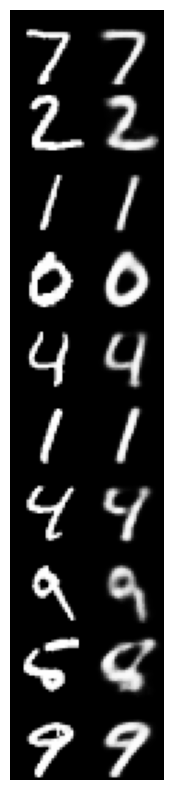

In [17]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [18]:
# use z_test_pred

In [19]:
from sklearn.manifold import TSNE

In [20]:
tsne = TSNE(n_components=2)

In [21]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

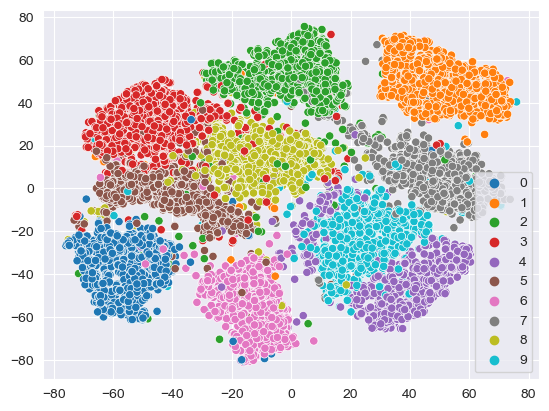

In [22]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

# h)

In [23]:
z_test_pred_new = np.random.multivariate_normal([0]*10, np.diag(np.diag(np.full([10, 10], 1))), 10)

In [24]:
test_pred_new = decoder.predict(z_test_pred_new)

1/1 [==============================] - 0s 16ms/step


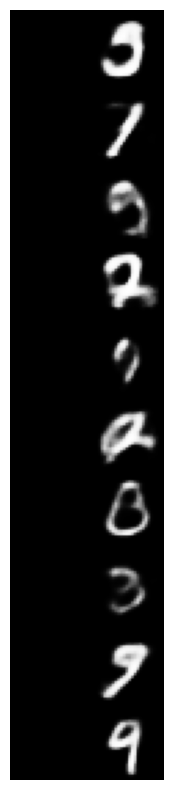

In [25]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred_new

for i in range(10):
    #figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


# Task 2

In [26]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim + 1))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(196, activation="relu")(x)
x = Dense(128, activation="tanh")(x)
x = Dense(64, activation="tanh")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 785)]                0         []                            
                                                                                                  
 dense_5 (Dense)             (None, 256)                  201216    ['input_3[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 196)                  50372     ['dense_5[0][0]']             
                                                                                                  
 dense_7 (Dense)             (None, 128)                  25216     ['dense_6[0][0]']             
                                                                                            

In [27]:
latent_inputs = keras.Input(shape=(latent_dim+1,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(196, activation="relu")(x)
x = Dense(128, activation="tanh")(x)
x = Dense(64, activation="tanh")(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_9 (Dense)             (None, 256)               3072      
                                                                 
 dense_10 (Dense)            (None, 196)               50372     
                                                                 
 dense_11 (Dense)            (None, 128)               25216     
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 784)               50960     
                                                                 
Total params: 137876 (538.58 KB)
Trainable params: 137876 (

In [28]:
class cVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            c = data[:, -1]
            c = tf.reshape(c, [-1, 1])

            reconstruction = self.decoder(tf.concat([z, c], 1))

            total_loss = -elbo_vae(data[:, :-1], reconstruction, z_mean, z_log_var)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}

In [29]:
x_train_c = np.concatenate((x_train, y_train.reshape(-1,1)), 1)

In [30]:
cvae = cVAE(encoder, decoder)
cvae.compile(optimizer=keras.optimizers.Adam())
cvae.fit(x_train_c, epochs=50, batch_size=128)


Epoch 1/50
469/469 [==============================] - 4s 6ms/step - loss: 262.3977
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 200.8663
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 183.9971
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 172.4565
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 160.7023
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 153.3293
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 148.8426
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 146.0074
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 143.7356
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 142.0828
Epoch 11/50
469/469 [==============================] - 3s 6ms/step - loss: 140.4965
Epoch 12/50
469/469 [==============================] - 3s 6ms/step - loss: 139.9056
E

### Task 2 f)

In [31]:
x_test_c = np.concatenate((x_test, y_test.reshape(-1,1)), 1)

In [32]:
# representation in the latent space of observations from test ds
z_test_pred_c = encoder.predict(x_test_c)# encoder predictions

313/313 [==============================] - 1s 2ms/step


In [33]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred_c = decoder.predict(np.concatenate((z_test_pred_c[2], y_test.reshape(-1,1)), 1))# decoder predictions - we take a vector from the latent space and transform it to be again a picture

313/313 [==============================] - 1s 1ms/step


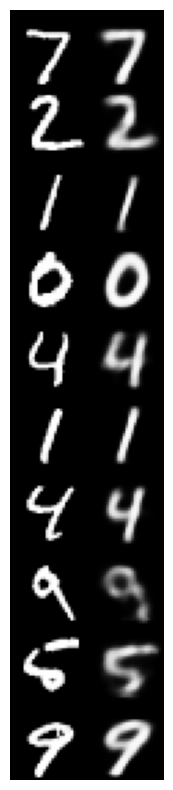

In [34]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred_c

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [35]:
# use z_test_pred

In [36]:
from sklearn.manifold import TSNE

In [37]:
tsne = TSNE(n_components=2)

In [38]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred_c[2])

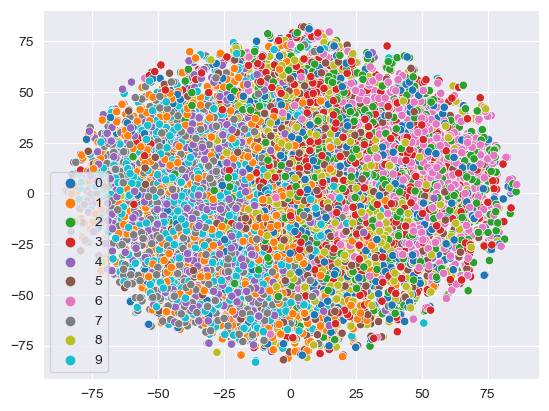

In [39]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

# h)

In [76]:
z_test_pred_new = np.random.multivariate_normal([0]*10, np.diag(np.diag(np.full([10, 10], 1))), 30)

In [77]:
# get 3 samples from each class
classes = []
for i in range(30):
    classes.append(i//3)

classes = np.asarray(classes).reshape(-1, 1)

In [78]:
classes

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3],
       [4],
       [4],
       [4],
       [5],
       [5],
       [5],
       [6],
       [6],
       [6],
       [7],
       [7],
       [7],
       [8],
       [8],
       [8],
       [9],
       [9],
       [9]])

In [79]:
test_pred_new = cvae.decoder.predict(np.concatenate((z_test_pred_new, classes), 1))

1/1 [==============================] - 0s 20ms/step


In [80]:
# test_pred_new

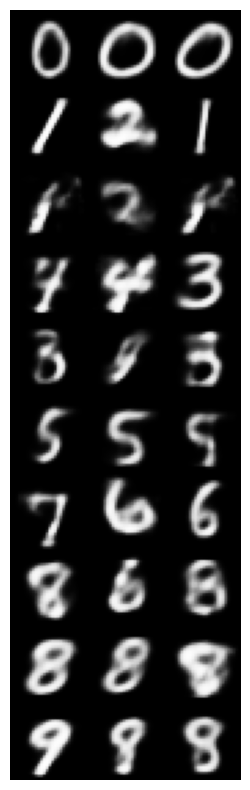

In [81]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size*3))
decoded = test_pred_new

for i in range(30):
    #figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i//3 * digit_size: (i//3 + 1) * digit_size, i%3 * digit_size: (i%3 + 1) * digit_size] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()
